In [ ]:
import os
import cv2  # For image processing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For displaying images
import pandas as pd
import geopandas as gpd
import os
import shutil
import glob
import pickle

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

from typing import Iterable, Any, List, Tuple, Callable

In [11]:
# Example of loading a raster image
RASTER_PATH = 'D:/deforestation-in-ukraine/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/' \
'S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/' \
'L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
    raster_image = src.read()
    raster_meta = src.meta

In [18]:
raster_image.shape

(3, 10980, 10980)

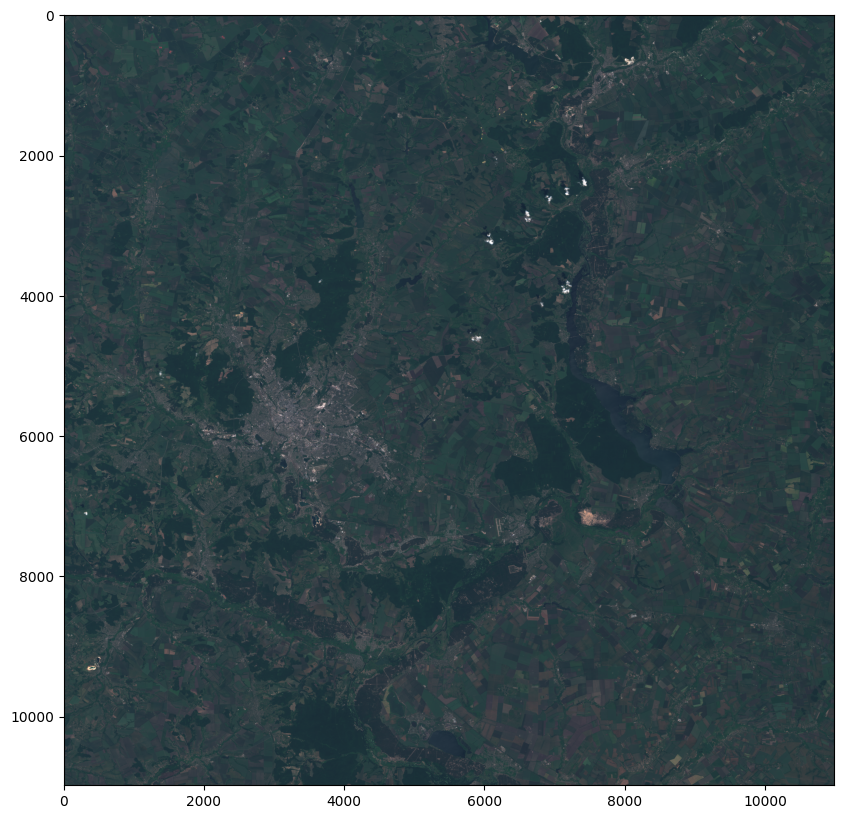

In [12]:
# Visualize the raster image
raster_img = reshape_as_image(raster_image)
plt.figure(figsize=(10, 10))
plt.imshow(raster_img)

Load dataset

In [33]:
# Define class for data loading
class ImageLoader:
    def __init__(self, base_dir: str, save_dir: str = None):
        self.pattern = '**/T36UYA_*_TCI.jp2' # template pattern to match files
        self.image_files = glob.glob(os.path.join(base_dir, self.pattern), recursive=True)

        self.save_dir = save_dir
        if self.save_dir is not None and not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        
    def __iter__(self):
        for image_file in self.image_files:
            image = self._load_image(image_file)

            # Check if image has more than 50% dammed pixels
            total_pixels = image.size
            num_black = np.sum(image == 0)
            num_white = np.sum(image == 255)
            percent_black = num_black / total_pixels
            percent_white = num_white / total_pixels

            if percent_black > 0.5 or percent_white > 0.5:
                print(f"Image {os.path.basename(image_file)} skipped: > 50% black or white pixels.")
                continue

            # Saving image to save_dir
            if self.save_dir is not None:
                save_path = os.path.join(self.save_dir, os.path.basename(image_file).replace('.jp2', '.jpg'))
                if not os.path.exists(save_path):
                   cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 90])

            print(f"Image {os.path.basename(image_file)} added")
            yield image

    def _load_image(self, image_path, max_dimension=1024):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if img is None:
            raise ValueError(f"Image not found or cannot be opened: {image_path}")
        
        height, width = img.shape[:2]
        scale = max_dimension / max(height, width)
        resized_img = cv2.resize(img, (int(width * scale), int(height * scale)))
        
        return resized_img


# Initialize and load images
def load_images(dir: str, save_dir: str = None, n_images: int=0):
    image_loader = ImageLoader(dir, save_dir)
    
    if n_images == 0:
        return [img for img in image_loader]

    images = []
    for i, img in enumerate(image_loader):
        images.append(img)
        if i >= n_images: break
    
    return images

In [17]:
# Set dataset paths
base_dataset_path = 'D:/deforestation-in-ukraine/'
save_dataset_path = './dev_dataset/'

images = load_images(base_dataset_path, save_dataset_path)

Image T36UYA_20160212T084052_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20160330T082542_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20160405T085012_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20160502T083602_TCI.jp2 added
Image T36UYA_20160509T082612_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20160618T082602_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20160621T084012_TCI.jp2 added
Image T36UYA_20160830T083602_TCI.jp2 added
Image T36UYA_20161026T083032_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20161121T085252_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20161205T083332_TCI.jp2 skipped: > 50% black or white pixels.
Image T36UYA_20190318T083701_TCI.jp2 added
Image T36UYA_20190328T084011_TCI.jp2 added
Image T36UYA_20190407T083601_TCI.jp2 added
Image T36UYA_20190417T083601_TCI.jp2 added
Image T36UYA_20190427T083601_TCI.jp2 added
Image T36UYA_20190517T083601_TCI.jp2 added
Image T36UYA_

In [16]:
# For deleting dataset if needed

# Check if the directory exists
if os.path.exists(save_dataset_path):
    try:
        # Use shutil.rmtree to remove the directory and its contents recursively
        shutil.rmtree(save_dataset_path)
        print(f"Directory at '{save_dataset_path}' and its contents deleted successfully.")
    except Exception as e:
        # Handle any errors that may occur during deletion
        print(f"Error deleting directory at '{save_dataset_path}': {e}")
else:
    print(f"Directory at '{save_dataset_path}' does not exist.")

Directory at './dev_dataset/' and its contents deleted successfully.


Check some dataset params:

In [19]:
len(images)

30

In [20]:
images[0].shape

(1024, 1024, 3)

In [21]:
images[0].max()

np.uint8(255)

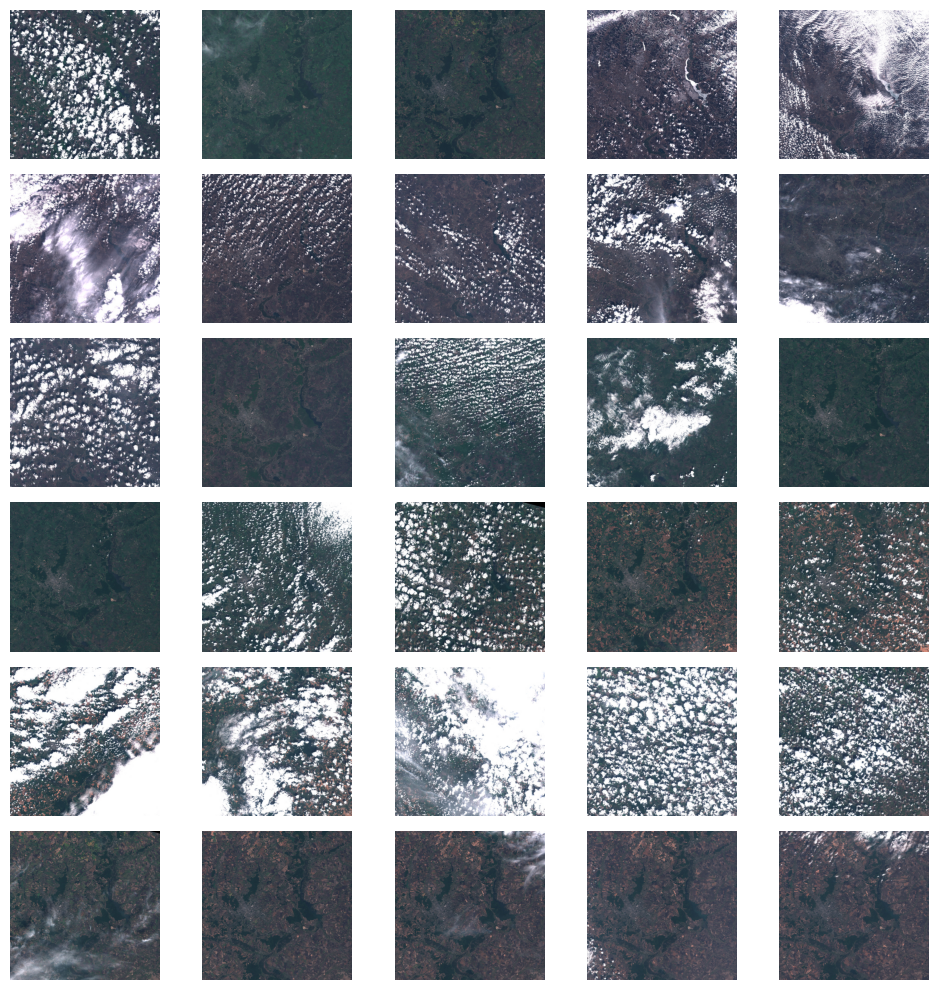

In [34]:
# Получаем список всех jpg изображений из save_dataset_path и вложенных папок
image_files = glob.glob(os.path.join(save_dataset_path, '**', '*.jpg'), recursive=True)

fig, ax = plt.subplots(ncols=5, nrows=6, figsize=(10, 10))
ax = ax.flatten()

for i, image_path in enumerate(image_files):
    if i >= len(ax):
        break
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].imshow(image)
    ax[i].axis('off')

plt.tight_layout()
plt.show()
